<a href="https://colab.research.google.com/github/Dovermore/COMP5046-ass1/blob/master/zhua9812_COMP5046_Ass1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP5046 Assignment 1
*Make sure you change the file name with your unikey.*

# Readme
*If there is something to be noted for the user, please mention here.* 

*If you are planning to implement a program with Object Oriented Programming style*

***Visualising the comparison of different results is a good way to justify your decision.***

## Please run EVERY cell in the object oriented section first

# 1 - Data Preprocessing

## 1.1. Download Dataset

In [0]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '1vF3FqgBC1Y-RPefeVmY8zetdZG1jmHzT'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('imdb_train.csv')

id = '1XhaV8YMuQeSwozQww8PeyiWMJfia13G6'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('imdb_test.csv')

import pandas as pd
df_train = pd.read_csv("imdb_train.csv")
df_test = pd.read_csv("imdb_test.csv")

reviews_train = df_train['review'].tolist()
sentiments_train = df_train['sentiment'].tolist()
reviews_test = df_test['review'].tolist()
sentiments_test = df_test['sentiment'].tolist()

print("Training set number:",len(reviews_train))
print("Testing set number:",len(reviews_test))

Training set number: 25000
Testing set number: 25000


## 1.2. Preprocess data

*You are required to describe which data preprocessing techniques were conducted with justification of your decision. *

#### Observe raw distribution

In [0]:
def check_preprocessing_step(reviews):
    null_params = (("rm_htmltag",False), ("expand_contraction",True), ("to_lower",True), 
                   ("rm_punctuation",False), ("cv_numbers",False), ("rm_accents",False),
                   ("stop_words",[]), ("lemmatize",False), ("min_count",0))
    steps_tokens = {}
    for i in range(len(processing_steps)+1):
        # Convert to params
        kwargs = dict(null_params[i:])
        # Add each training step and check statistics
        tokens = preprocess_texts(reviews, **kwargs)
        steps = tuple(a for a, v in null_params[:i])
        # Pair of processing steps applied/result tokens
        steps_tokens[i] = (steps, tokens)
    return steps_tokens

134450


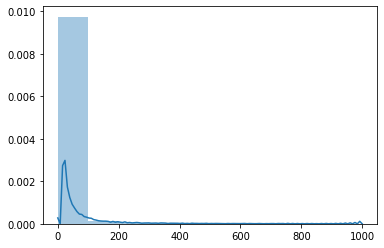

In [0]:
raw_tokens = preprocess_texts(reviews_train, rm_htmltag=False, expand_contraction=False, 
                              to_lower=False, rm_punctuation=False, cv_numbers=False,
                              stop_words=False, lemmatize=False, min_count=1)
show_token_stats(raw_tokens)

#### Observe processed Distribution

25365


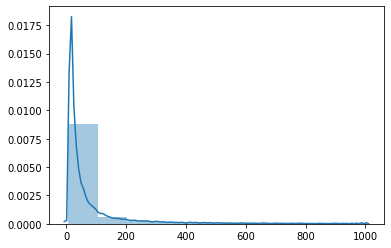

In [0]:
processed_tokens = preprocess_texts(reviews_train, min_count=5)
show_token_stats(processed_tokens)

In [0]:
tpt = TextPreprocessTransformer()
tokens_train = tpt.fit_transform(reviews_train)
tokens_test = tpt.transform(reviews_test)

total_len_train = 0
for tokens in tokens_train:
    total_len_train += len(tokens)

total_len_test = 0
for tokens in tokens_test:
    total_len_test += len(tokens)

print(tokens_train[:2])
print(tokens_test[:2])

print(total_len_train)
print(total_len_test)

[['enjoyed', 'movie', 'not', 'seen', 'andy', 'griffith', 'age', 'felt', 'fit', 'role', 'perfectly', 'associated', 'comedy', 'but', 'pleased', 'see', 'versatile', 'not', 'troubled', 'dotty', 'anxiety', 'disorder', 'may', 'not', 'verbatim', 'psychiatric', 'textbook', 'zillion', 'whatever', 'phobia', 'neurosis', 'broad', 'variety', 'form', 'clearly', 'sensitive', 'extra', 'sensory', 'power', 'understood', 'local', 'indian', 'but', 'not', 'anglos', 'not', 'surprising', 'character', 'vulnerable', 'eccentric', 'although', 'taken', 'light', 'family', 'movie', 'actually', 'sophisticated', 'seems', 'twist', 'came', 'pleasant', 'surprise', 'tied', 'preceding', 'action', 'together', 'bundle', 'fun', 'contemplate', 'possibility', 'spiritual', 'guidance'], ['whole', 'not', 'even', 'close', 'sum', 'part', 'no', 'problem', 'film', 'feature', 'line', 'creative', 'director', 'time', 'really', 'famous', 'name', 'cast', 'segment', 'devised', 'around', 'theme', 'love', 'paris', 'but', 'resemblance', 'end'

In [0]:
label_encoder = LabelEncoder()
label_encoder.fit(sorted(list(set(sentiments_train))))
label_train = label_encoder.transform(sentiments_train)
label_test = label_encoder.transform(sentiments_test)
print(label_train[:50])
print(label_test[:50])

[1 1 1 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 1 1 1 1 0 1 0 0 0 0 0
 0 0 0 0 1 1 0 0 1 0 0 1 1]
[1 0 0 0 0 0 1 1 0 1 0 1 0 1 1 0 0 1 1 1 0 1 1 0 1 1 0 0 0 1 1 0 1 0 0 1 0
 1 1 1 0 0 0 0 1 0 0 0 1 0]


In [0]:
# Save processed data
save_feather(tokens_train, label_train, sentiments_train, train_path)
save_feather(tokens_test, label_test, sentiments_test, test_path)

In [0]:
# Load from processed data
tokens_train, label_train, sentiments_train = load_feather(train_path)
tokens_test, label_test, sentiments_test = load_feather(test_path)

# 2 - Model Implementation

## 2.1. Word Embeddings

*You are required to describe which model was implemented (i.e. Word2Vec with CBOW, FastText with SkipGram, etc.) with justification of your decision *

### 2.1.1. Data Preprocessing for Word Embeddings

*You are required to describe which preprocessing techniques were used with justification of your decision.*

**Important**: If you are going to use the code from lab3 word2vec preprocessing. Please note that `word_list = list(set(word_list)) ` has randomness. So to make sure the word_list is the same every time you run it, you can put `word_list.sort()` after that line of code.

In [0]:
# Profile sample time with training data
sgt = VocabSkipGramTransformer(drop_prob=0)
sgt.fit(tokens_train)
datagen = sgt.generator(tokens_train)
%timeit -n 1000 next(datagen)
datagen = sgt.generator(tokens_train, algorithm=2)
%timeit -n 1000 next(datagen)
datagen = sgt.generator(tokens_train, algorithm=3)
%timeit -n 1000 next(datagen)

1000 loops, best of 3: 1.06 ms per loop
1000 loops, best of 3: 764 µs per loop
1000 loops, best of 3: 1.8 ms per loop


### 2.1.2. Build Word Embeddings Model

*You are required to describe how hyperparameters were decided with justification of your decision.*

(tensor([3, 7]), tensor([1, 6]), False)


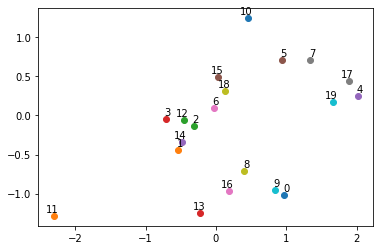

0
Saving net to:  /content/drive/My Drive/COMP5046-assignment1/test_w2v04140916/model0.pt


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type W2VSkipGramNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


(0m 9s) Epoch: 100, batch: 11700, loss: 2.2704
best
Saving net to:  /content/drive/My Drive/COMP5046-assignment1/test_w2v04140916/modelbest.pt
1
Saving net to:  /content/drive/My Drive/COMP5046-assignment1/test_w2v04140916/model1.pt
(0m 18s) Epoch: 200, batch: 23400, loss: 2.2241
2
Saving net to:  /content/drive/My Drive/COMP5046-assignment1/test_w2v04140916/model2.pt
(0m 27s) Epoch: 300, batch: 35100, loss: 2.2207
3
Saving net to:  /content/drive/My Drive/COMP5046-assignment1/test_w2v04140916/model3.pt
(0m 36s) Epoch: 400, batch: 46800, loss: 2.2204
4
Saving net to:  /content/drive/My Drive/COMP5046-assignment1/test_w2v04140916/model4.pt
(0m 45s) Epoch: 500, batch: 58500, loss: 2.2194
5
Saving net to:  /content/drive/My Drive/COMP5046-assignment1/test_w2v04140916/model5.pt
Loading net from:  /content/drive/My Drive/COMP5046-assignment1/test_w2v04140916/model5.pt


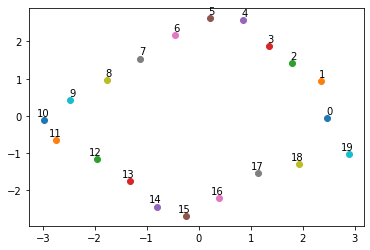

In [0]:
test_w2v_model = make_w2v_model(X=toy_num_data, embedding_dim=2, 
                                window=3, ckpt_base="test_w2v", addtime=True)
datagen = test_w2v_model.data_generator(toy_num_data, batch_size=2)
print(next(datagen))
# Before
vocab_list = test_w2v_model.data_transformer.token_list
plot_annotate(*list(zip(*test_w2v_model.net.embedding.weight.detach().numpy())), vocab_list)
plt.show()
test_w2v_model.train(train_data=toy_num_data, epochs=500, batch_size=2, 
                     batch_display_interval=0, epoch_display_interval=100, ckpt_interval=100)
# After
test_w2v_model.load_model()
# Overfit the small dataset
plot_annotate(*list(zip(*test_w2v_model.net.embedding.weight.detach().numpy())), vocab_list)
plt.show()
# I think this works?

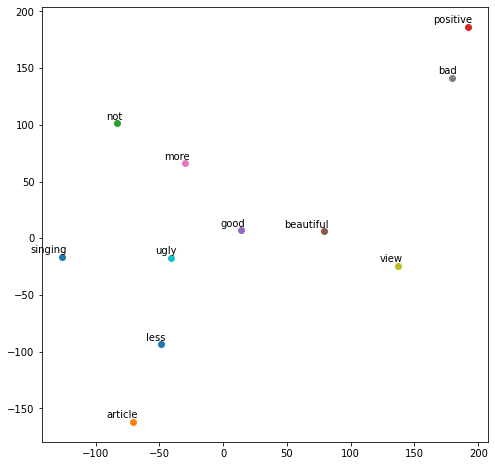

Saving net to:  /content/drive/My Drive/COMP5046-assignment1/test_w2v04141224/zhua9812_word0.pt
    (0m 0s) Batch: 50, loss: 2.4123


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type W2VSkipGramNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


    (0m 0s) Batch: 100, loss: 2.3094
    (0m 0s) Batch: 150, loss: 2.2298
    (0m 0s) Batch: 200, loss: 2.1658
    (0m 0s) Batch: 250, loss: 2.1127
    (0m 0s) Batch: 300, loss: 2.0672
    (0m 0s) Batch: 350, loss: 2.0270
    (0m 0s) Batch: 400, loss: 1.9910
    (0m 0s) Batch: 450, loss: 1.9585
    (0m 0s) Batch: 500, loss: 1.9294
    (0m 0s) Batch: 550, loss: 1.9033
    (0m 1s) Batch: 600, loss: 1.8802
    (0m 1s) Batch: 650, loss: 1.8598
    (0m 1s) Batch: 700, loss: 1.8418
    (0m 1s) Batch: 750, loss: 1.8255
    (0m 1s) Batch: 800, loss: 1.8106
    (0m 1s) Batch: 850, loss: 1.7965
    (0m 1s) Batch: 900, loss: 1.7830
    (0m 1s) Batch: 950, loss: 1.7695
    (0m 1s) Batch: 1000, loss: 1.7559
    (0m 1s) Batch: 1050, loss: 1.7420
    (0m 1s) Batch: 1100, loss: 1.7280
    (0m 1s) Batch: 1150, loss: 1.7140
    (0m 2s) Batch: 1200, loss: 1.7003
    (0m 2s) Batch: 1250, loss: 1.6873
    (0m 2s) Batch: 1300, loss: 1.6750
    (0m 2s) Batch: 1350, loss: 1.6636
    (0m 2s) Batch: 1400, loss:

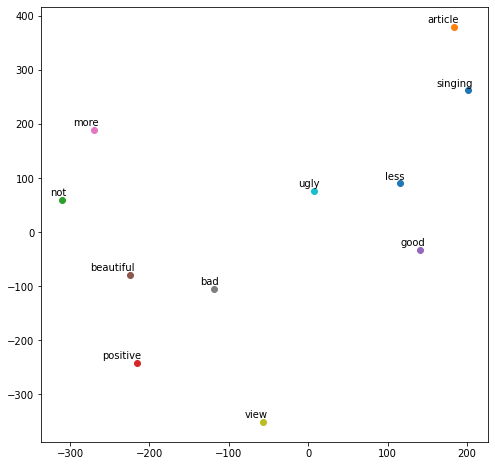

In [0]:
test_embedding_dim = 6
test_window = 3
perplexity = 3
test_w2v_model = make_w2v_model(X=toy_data, embedding_dim=test_embedding_dim, 
                                window=test_window, ckpt_base="test_w2v", addtime=True)
_ = plot_w2v_topk(test_w2v_model, toy_data, method="TSNE", k=100, perplexity=perplexity)
# _ = plot_w2v_topk(test_w2v_model, toy_data, method="PCA", k=100)
# vocab_list = test_w2v_model.data_transformer.token_list
# plot_annotate(*list(zip(*test_w2v_model.net.embedding.weight.detach().numpy())), vocab_list)
# plt.show()
test_w2v_model.train(train_data=toy_data, epochs=2000, batch_display_interval=50)
_ = plot_w2v_topk(test_w2v_model, toy_data, method="TSNE", k=100, perplexity=perplexity)
# _ = plot_w2v_topk(test_w2v_model, toy_data, method="PCA", k=100)
# vocab_list = test_w2v_model.data_transformer.token_list
# plot_annotate(*list(zip(*test_w2v_model.net.embedding.weight.detach().numpy())), vocab_list)
# plt.show()


# Negative words seems to have clustered together

### 2.1.3. Train Word Embeddings Model

In [0]:
embedding_dim, window, drop_prob = 64, 5, 0

In [0]:
w2v_model = make_w2v_model(tokens_train, embedding_dim, window, drop_prob)
# 100 is the most I can run, else colab disconnects
w2v_model_trails = w2v_model.train(train_data=tokens_train, epochs=100, batch_size=1024, 
                                   batch_display_interval=10000, epoch_display_interval=1, ckpt_interval=1)

Saving net to:  /content/drive/My Drive/COMP5046-assignment1/word/zhua9812_word0.h5


### 2.1.4. Save Word Embeddings Model

In [0]:
# Adding _ to the end because it should already be saved once
w2v_model.save_model("best_")

Saving net to:  /content/drive/My Drive/COMP5046-assignment1/word/zhua9812_wordbest_.h5


### 2.1.5. Load Word Embeddings Model

In [0]:
# Setup
w2v_model_load = make_w2v_model(tokens_train, embedding_dim, window, drop_prob)
w2v_model_load.load_model("best")
w2v_model_load.mode(False)

Loading net from:  /content/drive/My Drive/COMP5046-assignment1/word/zhua9812_wordbest.h5


## 2.2. Character Embeddings

### 2.2.1. Data Preprocessing for Character Embeddings

*You are required to describe which preprocessing techniques were used with justification of your decision.*

In [0]:
cet = VocabCharacterTransformer().fit(toy_num_data)
cet.transform(toy_num_data)
# It works

### 2.2.2. Build Character Embeddings Model

*You are required to describe how hyperparameters were decided with justification of your decision.*

In [0]:
test_embedding = test_w2v_model.net.embedding
test_char_model = make_char_model(toy_data, test_embedding, ckpt_base="test_char", addtime=True)
_ = test_char_model.train(train_data=toy_data, epochs=5000, batch_display_interval=1000)

Saving net to:  /content/drive/My Drive/COMP5046-assignment1/test_char04141224/zhua9812_character0.pt


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CharacterEmbedNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


    (0m 9s) Batch: 1000, loss: 0.0009
    (0m 17s) Batch: 2000, loss: 0.0001
    (0m 26s) Batch: 3000, loss: 0.0000
    (0m 34s) Batch: 4000, loss: 0.0000
    (0m 42s) Batch: 5000, loss: 0.0000


### 2.1.4. Train Character Embeddings Model

In [0]:
embedding = w2v_model_load.net.embedding
char_model = make_char_model(tokens_train, embedding=embedding, hidden_size=128)
char_model_trails = char_model.train(train_data=tokens_train, epochs=1, batch_display_interval=5000, 
                                     epoch_display_interval=1, ckpt_interval=1)

Saving net to:  /content/drive/My Drive/COMP5046-assignment1/character/zhua9812_character0.h5
(11m 16s) Epoch: 1, batch: 2916, loss: 0.6825
Saving net to:  /content/drive/My Drive/COMP5046-assignment1/character/zhua9812_character1.h5


### 2.1.5. Save Character Embeddings Model

In [0]:
char_model.save_model("best_")

Saving net to:  /content/drive/My Drive/COMP5046-assignment1/character/zhua9812_characterbest.h5


### 2.1.6. Load Character Embeddings Model

In [0]:
embedding = w2v_model_load.net.embedding
char_model_load = make_char_model(tokens_train, embedding, ckpt_base="character")
char_model_load.load_model("best")
char_model_load.mode(False)

Loading net from:  /content/drive/My Drive/COMP5046-assignment1/character/zhua9812_characterbest.h5


## 2.3. Sequence model

### 2.3.1. Apply/Import Word Embedding and Character Embedding Model

*You are required to describe how hyperparameters were decided with justification of your decision.*

### 2.3.2. Build Sequence Model

*You are required to describe how hyperparameters were decided with justification of your decision.*

### 2.3.3. Train Sequence Model

In [0]:
# Test model
test_hidden_size = 3
test_char_net = test_char_model.net
seq_net = make_sequence_model(toy_full_data11, test_embedding, test_char_net, test_hidden_size, 
                              ckpt_base="test_seq", addtime=True)

In [0]:
test_run = wandb_init({"hidden_size": 3, "rnn_type": "LSTM"}, tags=["test_seq"])
with test_run:
    seq_net.train(train_data=toy_full_data11, val_data=toy_full_data_test, epochs=3200, batch_size=6, 
                epoch_display_interval=200, ckpt_interval=10000, epoch_validation_interval=400,
                wandb_log=True)

Saving net to:  /content/drive/My Drive/COMP5046-assignment1/test_seq04141252/zhua9812_sequence0.h5
(0m 6s) Epoch: 200, batch: 400, loss: 0.1665
Validation - epoch 400:
    Loss: 0.6282
    accuracy: 71.43%
    F1: 0.8000
(0m 12s) Epoch: 400, batch: 800, loss: 0.0353
(0m 18s) Epoch: 600, batch: 1200, loss: 0.0149
Validation - epoch 800:
    Loss: 0.8137
    accuracy: 71.43%
    F1: 0.8000
(0m 24s) Epoch: 800, batch: 1600, loss: 0.0081
(0m 30s) Epoch: 1000, batch: 2000, loss: 0.0046
Validation - epoch 1200:
    Loss: 0.9380
    accuracy: 71.43%
    F1: 0.8000
(0m 37s) Epoch: 1200, batch: 2400, loss: 0.0031
(0m 43s) Epoch: 1400, batch: 2800, loss: 0.0022
Validation - epoch 1600:
    Loss: 1.0248
    accuracy: 71.43%
    F1: 0.8000
(0m 49s) Epoch: 1600, batch: 3200, loss: 0.0016
(0m 56s) Epoch: 1800, batch: 3600, loss: 0.0012
Validation - epoch 2000:
    Loss: 1.1092
    accuracy: 71.43%
    F1: 0.8000
(1m 2s) Epoch: 2000, batch: 4000, loss: 0.0010
(1m 8s) Epoch: 2200, batch: 4400, loss: 

NameError: ignored

In [0]:
# Actual model
hidden_size = embedding_dim // 4
seq_net = make_sequence_model([tokens_train, label_train], w2v_model_load.net.embedding, 
                               char_model_load.net, hidden_size, ckpt_base="seq")
seq_net_trail = seq_net.train([tokens_train, label_train], 100, batch_display_interval=5000, 
                              epoch_display_interval=1, ckpt_interval=1)

### 2.3.4. Save Sequence Model

In [0]:
seq_net.save_model("best_")

### 2.3.5. Load Sequence Model

In [0]:
# Please comment your code
hidden_size = w2v_model_load.net.embedding.embedding_dim / 4
seq_net = make_sequence_model([tokens_train, label_train], w2v_model_load.net.embedding, 
                            char_model_load.net, hidden_size, ckpt_base="seq")
seq_net_load.load_model("best")
seq_net_load.mode(False)

NameError: ignored

# 3 - Evaluation

(*Please show your empirical evidence*)

## 3.1. Performance Evaluation


You are required to provide the table with precision, recall, f1 of test set.

In [0]:
# Please comment your code

## 3.2. Hyperparameter Testing
*You are required to draw a graph(y-axis: f1, x-axis: epoch) for test set and explain the optimal number of epochs based on the learning rate you have already chosen.*

In [0]:
# Please comment your code


3

## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed* 

In [0]:
# install some other necessary libraries
# Expand contractions
%pip install unicode
%pip install contractions
%pip install torchviz
%pip install wandb
!wandb login 313fbc32f5d8eafb89fc6611be0e05e4a71ef77f

# Setup saving and loading
from google.colab import files, drive
from pathlib import Path

# All imports
import copy
from copy import deepcopy
import re
import os
import time
from datetime import datetime
import math
from collections import Counter
from random import shuffle, getrandbits, sample
import json

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.base import TransformerMixin
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.decomposition import PCA

from unidecode import unidecode

from bs4 import BeautifulSoup
import contractions

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords as sw
from nltk import FreqDist

from matplotlib import pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils import data
from torch.optim import Adam
from torch.nn import functional as F
from torch.nn.utils.rnn import pack_sequence

from torchviz import make_dot

import wandb

Requirement already up-to-date: wandb in /usr/local/lib/python3.6/dist-packages (0.8.31)
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
## Setup some variables
# Prepare some Toy data
toy_token_1data = [["hello"]]
toy_token_10data = [["hello", "below", "allow", "law", "low", "all", "halo", 
                     "hellobelowallow", "lawlow", "halo"]]

toy_token_data11 = [
                      ["good", "article"],
                      ["beautiful", "article", "good"],
                      ["beautiful", "singing", "more"],
                      ["not", "bad", "view"],
                      ["not", "ugly", "singing", "positive"],
                      ["more", "positive", "singing"],
                      ["less", "positive", "article"],
                      ["bad", "singing"],
                      ["not", "positive", "article"],
                      ["not", "good", "singing"],
                      ["ugly", "view"],
                      ]
toy_sentiment_data11 = [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]

toy_token_data_test = [
                    # Test if it can handle unseen words (should ignore it)
                      ["more", "impressive", "singing", "not", "bad"],

                      ["not", "ugly", "article"],
                      ["beautiful", "view"],
                      ["more", "good", "singing", "positive"],
                      ["less", "bad", "view"],
                      ["less", "good", "article"],
                      ["not", "beautiful", "view"],
                      ]
toy_sentiment_data_test = [1, 1, 1, 1, 0, 0, 0]

toy_full_data11 = [toy_token_data11, toy_sentiment_data11]
toy_full_data_test = [toy_token_data_test, toy_sentiment_data_test]
toy_data = toy_token_data11
toy_num_data = np.array(list(range(20)) * 2 + [0]).reshape(1, -1).tolist()

# Setup drive path
drive.mount('/content/drive')
drive_path = Path("/content/drive/My Drive/COMP5046-assignment1/")

# Processed train and test data
train_path = drive_path/"data"/"train.feather"
test_path = drive_path/"data"/"test.feather"

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print("device is ", device)

# For reproducibility
# Also the ultimita solution to universe -- The Hitchhiker's Guide to the Galaxy
torch.manual_seed(42)
np.random.seed(42)

# List of generic hyperparameters
# optimizer: lr, *args, **kwargs
# epochs, batch_size
# w2v: embedding_dim, window, drop_prob
w2v_configs_path = drive_path/"config"/"w2v_configs.json"
# char: ?[gru, lstm, rnn], hidden_size, dropout, num_layers
char_configs_path = drive_path/"config"/"char_configs.json"
# seq: ?[gru, lstm, rnn], hidden_size, dropout, num_layers
seq_configs_path = drive_path/"config"/"seq_configs.json"

wandb_dir = drive_path
wandb_api_

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
device is  cpu


In [0]:
## Setup helper functions
def read_json(path):
    """
    Load json config
    """
    with open(path, "r") as fp:
        config = json.load(fp)
    return config


def wandb_init(config_dict, tags=[], project="comp5046-assignment1", wandb_dir=wandb_dir, 
               reinit=True, *args, **kwargs):
    """
    Simply set some default parameters
    """
    return wandb.init(config=config_dict, tags=tags, project=project, dir=str(wandb_dir), 
                      reinit=reinit, *args, **kwargs)


def get_time_str(*args, **kwargs):
    """
    Get current time in string format
    """
    return datetime.now(*args, **kwargs).strftime("%m%d%H%M")

    
def check_create_parent(path):
    """
    Check and create the parent path of a given file path
    """
    path = Path(path)
    if not (path.parent.exists() and path.parent.is_dir()):
        path.parent.mkdir(parents=True, exist_ok=False)


# Create df to store the data
def save_feather(tokens, labels, sentiments, path):
    """
    Save processed data in feather format for faster loading
    """
    df = pd.DataFrame(columns=["tokens", "labels", "sentiments"])
    df["tokens"] = [" ".join(t) for t in tokens]
    df["labels"] = labels 
    df["sentiments"] = sentiments
    check_create_parent(path)
    df.to_feather(path)


def load_feather(path):
    """
    Load processed data saved in feather format for faster loading
    """
    df = pd.read_feather(path)
    tokens = df["tokens"]
    labels = df["labels"]
    sentiments = df["sentiments"]
    tokens = [t.split(" ") for t in tokens]
    return tokens, labels, sentiments


def time_since(since):
    """
    Format the time since a given timepoint in string
    Accreditation: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
    """
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def birnn_last_concat(rnn, X):
    """
    Pass data X through a given rnn (lstm, gru) and return the final concat result as tensor
    """
    if isinstance(rnn, nn.LSTM):
        out_seq, (h_n, c_n) = rnn(X)
    else:
        out_seq, h_n = rnn(X)
    # h_n of shape (num_layers * num_directions, batch, hidden_size): 
    #     tensor containing the hidden state for t = seq_len.
    h_n = h_n.view(rnn.num_layers, 2, -1, rnn.hidden_size)
    # concat the last hidden state from two direction
    out = torch.cat((h_n[-1,0,:,:], h_n[-1,1,:,:]),1)
    return out


def sort_pack_chars(X, num_classes):
    """
    Sort and pack uneven length character arrays in torch to one-hot encoded packed sequence
    """
    # Sort by length and convert to tensor
    X, idxs = mysorted([torch.from_numpy(np.array(x)) for x in X], 
                                key=lambda x: len(x), reverse=True)
    # Change to one hot encoding and word vector
    X = pack_sequence([F.one_hot(seq, num_classes=num_classes).float() for seq in X])
    return X, idxs


def unpack_sequence(packed_sequence):
    """
    Unpack a packedsequence provided in sort_pack_chars (but won't reverse the order)
    """
    batch_sizes = packed_X.batch_sizes.clone().numpy()
    lengths = []
    while batch_sizes[0]:
        lengths.append(sum(batch_sizes > 0))
        batch_sizes -= 1
    head = 0
    trailing_dims = packed_sequence.data.shape[1:]
    unpacked_sequence = [torch.zeros(l, *trailing_dims) for l in lengths]
    # l_idx - goes from 0 - maxLen-1
    for l_idx, b_size in enumerate(packed_sequence.batch_sizes):
        for b_idx in range(b_size):
            unpacked_sequence[b_idx][l_idx] = packed_sequence.data[head]
            head += 1
    return unpacked_sequence


def get_net_dict(net:nn.Module):
    """
    Deepcopy and extract the state_dict of a module
    """
    return deepcopy(net.state_dict())


def mysorted(seq, key=None, reverse=False):
    """
    Emulate torch.sort behaviour for a regular list
    returns the sorte seqeunce and the index list to sort it
    """
    idxs, seq = list(zip(*sorted(enumerate(seq), key=lambda x: key(x[1]), reverse=reverse)))
    return seq, list(idxs)


def plot_annotate(x, y, labels, ax=None):
    """
    Plot and annotate points given by x, y with list of labels
    """
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                    xy=(x[i], y[i]),
                    xytext=(5, 2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom')


def plot_embedding_tsne(embedding, labels, *args, **kwargs):
    embedding_data = embedding.weight.clone().detach().numpy()
    if isinstance(labels, dict):
        labels, idx = zip(*list(labels.items()))
        embedding_data = embedding_data[list(idx)]
    tsne = TSNE(*args, **kwargs)
    tsne_embedding = tsne.fit_transform(embedding_data).tolist()
    plot_annotate(*list(zip(*tsne_embedding)), labels)
    plt.show()
    return tsne_embedding, embedding_data, tsne


def plot_embedding_pca(embedding, labels, n_components=2, *args, **kwargs):
    embedding_data = embedding.weight.clone().detach().numpy()
    if isinstance(labels, dict):
        labels, idx = zip(*list(labels.items()))
        embedding_data = embedding_data[list(idx)]
    pca = PCA(n_components, *args, **kwargs)
    pca_embedding = pca.fit_transform(embedding_data).tolist()
    plot_annotate(*list(zip(*pca_embedding)), labels)
    plt.show()
    return pca_embedding, embedding_data, pca


class FileNameGenerator:
    def __init__(self, prefix, postfix=".pt"):
        self.prefix = prefix
        self.postfix = postfix

    def _gen_fname(self, offset=0):
        i = 0
        path = self._format_path(i)
        while path.exists():
            i += 1
            path = self._format_path(i)
        if i + offset < 0:
            return None
        return self._format_path(i + offset)
    
    def read_fname(self, serial=None):
        if serial is None:
            return self._gen_fname(offset=-1)
        return self._format_path(serial)

    def write_fname(self, serial=None):
        if serial is None:
            return self._gen_fname()
        return self._format_path(serial)
    
    def _format_path(self, serial):
        return Path("%s%s%s" % (self.prefix, str(serial), self.postfix))

In [0]:
# Base NN model training and testing frame
class BaseModel:
    def __init__(self, net:nn.Module, optimizer, ckpt_fname_gen:FileNameGenerator, 
                 device=device, save_dict=False):
        super().__init__()
        # data transformer for transforming/generating data
        self.data_transformer = VocabCardinalTransformer()
        # store optimizer
        self.optimizer = optimizer
        # ckpt name generator
        self.ckpt_fname_gen = ckpt_fname_gen
        # loss (should be overridden if needed)
        self._loss = nn.CrossEntropyLoss()
        # device this is trained on
        self.device = device
        # State of the model
        self.training = True
        self.best_net_dict = None

        # Determines the format to save model (h5 or pt)
        self.save_dict = save_dict

        self._net = None
        if net is not None:
            self.net = net

    def train_step(self, X_batch, y_batch):
        # zero the parameter gradients
        self.optimizer.zero_grad()
    
        # forward + backward + optimize
        outputs = self.net.forward(X_batch)
        loss = self.loss(outputs, y_batch)
        loss.backward()
        self.optimizer.step()
        return outputs, loss

    def train(self, train_data, val_data=None, epochs=100, batch_size=1024, batch_display_interval=0, 
              epoch_display_interval=0, epoch_validation_interval=1, ckpt_interval=0, wandb_log=False, 
              return_trail=True):
        if batch_display_interval <= 0:
            batch_display_interval = 1e10
        if epoch_display_interval <= 0:
            epoch_display_interval = 1e10
        if ckpt_interval <= 0:
            ckpt_interval = 1e10

        self.net.to(self.device)
        data_gen = self.data_generator(train_data, batch_size=batch_size)

        X_val, y_val, val_flag = None, None, False
        if epoch_validation_interval <= 0:
            epoch_validation_interval = 1000000000
        elif val_data is not None:
            X_val, y_val = self.data_transformer.transform(val_data)
            X_val, y_val = self.process_npbatch(X_val, y_val)
            X_val = X_val.to(device)
            y_val = y_val.to(device)
            val_flag = True

        batch = 0
        start = time.time()
        best_net_loss = np.inf
        epoch_loss_trail = {}
        epoch_val_loss_trail = {}
        epoch_val_eval_trail = {}

        # Turns on automatic logging as well
        if wandb_log is True:
            wandb.watch(self.net, log="all")

        if 0 < ckpt_interval < 1e10:
            self.save_model(0)
        for epoch in range(epochs):
            epoch_loss = 0
            epoch_size = 0
            for X_batch, y_batch, end_epoch in data_gen:
                # Send data to the device
                X_batch = X_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                # Train
                outputs, loss = self.train_step(X_batch, y_batch)
                # Weigh the loss by batch size
                epoch_loss += loss * y_batch.size(0)
                epoch_size += batch_size

                if batch % batch_display_interval == batch_display_interval - 1: 
                    print('    (%s) Batch: %d, loss: %.4f' %(time_since(start), batch + 1, loss))
                batch += 1
                # End epoch if data generator exhausted
                if end_epoch:
                    break

            epoch_loss /= epoch_size
            epoch_loss_trail[epoch+1] = epoch_loss

            # If Validation set is given, then choose the best model according to val set
            if val_flag:
                if (epoch % epoch_validation_interval == epoch_validation_interval - 1):
                    with torch.no_grad():
                        # forward
                        val_out = self.net.forward(X_val)
                        val_loss = self.loss(val_out, y_val)

                        # evaluate based on given metrics
                        val_eval = self.eval(val_out, y_val)
                        epoch_val_loss_trail[epoch+1] = val_loss
                        epoch_val_eval_trail[epoch+1] = val_eval

                        # print the valiation detail if needed
                        self.eval_print(val_eval, epoch+1)

                        # Update best model if needed
                        if val_loss < best_net_loss:
                            best_net_loss = val_loss
                            self.best_net_dict = get_net_dict(self.net)
                            self.save_model("best")

            # Log training loss
            if wandb_log is True:
                # Validation data also evaluated this epoch
                if val_flag and (epoch % epoch_validation_interval == epoch_validation_interval - 1):
                    # Log validation evaluations
                    wandb.log(
                        dict({"val_loss": val_loss}, 
                             **{("val_" + k): v for k, v in val_eval.items()}), 
                              step=epoch+1, commit=False)
                # Log training loss and commit
                wandb.log({"train_loss": epoch_loss, 
                           "epoch"=epoch+1}, step=epoch+1, commit=True)

            # Print training loss
            if epoch % epoch_display_interval == epoch_display_interval - 1: 
                print('(%s) Epoch: %d, batch: %d, loss: %.4f' %(time_since(start), epoch + 1, 
                                                                batch, epoch_loss))

            # If Validation set is given, then use training set to determine best model
            elif epoch_loss < best_net_loss:
                best_net_loss = epoch_loss
                self.best_net_dict = get_net_dict(self.net)
                if epoch % ckpt_interval == ckpt_interval - 1: 
                    self.save_model("best")

            # Save a checkpoint of training incase the notebook dc
            if epoch % ckpt_interval == ckpt_interval - 1: 
                self.save_model((epoch+1) // ckpt_interval)

        # Finished trianing, load back the best dict
        self.net.load_state_dict(self.best_net_dict)

        # Log that this run finished (in case of disconnect)
        if wandb_log is True:
            wandb.log({"finish": True})

        # Return trail if needed
        if return_trail:
            if val_flag:
                return epoch_loss_trail, epoch_val_loss_trail, epoch_val_eval_trail
            return epoch_loss_trail
            
    def data_generator(self, X, batch_size):
        if self.training:
            self.fit_transformer(X)
        X, y = self.data_transformer.transform(X)
        batch_per_epoch = math.ceil(y.shape[0]/batch_size)
        while True:
            indices = np.arange(y.shape[0])
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]
            for m in range(batch_per_epoch):
                X_batch = X[m * batch_size : (m + 1) * batch_size]
                y_batch = y[m * batch_size : (m + 1) * batch_size]
                X_batch, y_batch = self.process_npbatch(X_batch, y_batch)
                end_epoch = False
                if m == batch_per_epoch - 1: end_epoch = True 
                yield X_batch, y_batch, end_epoch
    
    def process_npbatch(self, X_batch, y_batch):
        return torch.from_numpy(X_batch), torch.from_numpy(y_batch)

    def save_model(self, serial=None):
        if self.save_dict is False:
            self.ckpt_fname_gen.postfix = ".pt"
            save_obj = self.net
        else:
            self.ckpt_fname_gen.postfix = ".h5"
            save_obj = self.net.state_dict()
        path = Path(self.ckpt_fname_gen.write_fname(serial))
        print("Saving net to: " , path)
        check_create_parent(path)
        torch.save(save_obj, path)


    def load_model(self, serial=None):
        if self.save_dict is False:
            self.ckpt_fname_gen.postfix = ".pt"
            path = self.ckpt_fname_gen.read_fname(serial)
            print("Loading net from: " , path)
            self.net = torch.load(path, map_location=self.device)
        else:
            self.ckpt_fname_gen.postfix = ".h5"
            path = self.ckpt_fname_gen.read_fname(serial)
            print("Loading net from: " , path)
            self.net.load_state_dict(torch.load(path, map_location=self.device))

    def mode(self, training=True):
        self.training = training
        self.net.train(training)

    @property
    def net(self):
        return self._net

    @net.setter
    def net(self, net):
        # Store model
        self._net = net 
        # Send to the device
        self._net.to(self.device)
        # Update best dict
        self.best_net_dict = get_net_dict(self._net)

    def fit_transformer(self, X):
        self.data_transformer.fit(X)
        return self

    def loss(self, input, target):
        return self._loss(input, target)

    def eval(self, output, target):
        with torch.no_grad():
            return None

    def eval_print(self, eval, epoch):
        pass

    def eval_log(self, eval, epoch, type="val"):
        pass



def visualise_loss_graph(model, data):
    """
    Visualise the computation graph of a model's loss
    """
    X_batch, y_batch, _ = next(model.data_generator(data, batch_size=2))
    out, loss = model.train_step(X_batch, y_batch)
    param_dict = dict(list(model.net.named_parameters()))
    make_dot(loss, params=param_dict)

In [0]:
## Setup preprocessing

# These words affect the reasoning of the sentence
negative_words = set(["no", "nor", "not", "but"])
stop_words = set(sw.words()) - negative_words
# Lemmatise the words
lemmatizer = WordNetLemmatizer()

def remove_punctuation(x):
    """
    Remove all non white space or word character in function x
    :param x: The sentence to process
    :return: str with all non white space or word character removed
    """
    x = re.sub(r'[^\w\s]',' ',x)
    return x

def convert_numbers(x):
    """
    Convert numbers to number token
    :param x: The sentence to process
    :return: str with all numbers converted accordingly
    """
    # Replace digit of different length with corresponding token
    x = re.sub(r'[0-9]{5,}', '5num', x)
    x = re.sub(r'[0-9]{4}', '4num', x)
    x = re.sub(r'[0-9]{3}', '3num', x)
    x = re.sub(r'[0-9]{2}', '2num', x)
    # Remove fraction symbols (and other other category symbol)
    x = re.sub(r'[½¾]', '', x)
    return x

def preprocess_texts(X, rm_htmltag=True, expand_contraction=True, to_lower=True, rm_punctuation=True,
                     cv_numbers=True, rm_accents=True, stop_words=stop_words, lemmatize=True, min_count=5):
    """
    Preprocess texts with the specified preprocessing procedures
    :param X: A list of texts to be processed
    :param rm_htmltag: If html tags should be removed
    :param expand_contraction: If contraction should be expanded
    :param to_lower: If cases should be converted to lower case
    :param rm_punctuation: If punctuation should be removed
    :param lemmatize: If tokens should be lemmatized
    :return: list[list[processed token]]
    """
    if rm_htmltag:
        # Use beautiful soup to remove html tags if any
        X = [BeautifulSoup(s).get_text() for s in X]

    if expand_contraction:
        # expand contactions (english only) to normalise text (this before lower case because this will give uppercase)
        X = [contractions.fix(s) for s in X]

    if to_lower:
        # Case folding is necessary to reduce the unique words and removing some irregular case formulation for words.
        # Though this may cause the loss of some information (for instance, all CAPPED words have strong emotion),
        # it is generally beneficial to smooth the occurances of words
        X = [s.lower() for s in X]

    if rm_punctuation:
        # Remove punctuations is necessary for almost the same reason as the case folding. Here because each tweet is self
        # contained, no need to add end of sentence token.
        X = [remove_punctuation(s) for s in X]

    if cv_numbers:
        X = [convert_numbers(s) for s in X]
    
    if rm_accents:
        X = [unidecode(s) for s in X]

    # Tokenization is necessary to extract each individual words instead of feeding in raw sentences.
    X = [word_tokenize(sent) for sent in X]

    # Stop words are NOT removed (yet) for they sometimes affect the sentiment by a lot (like word not, wouldn't)
    # If I can get better list and spend more time understanding the data then I will remove them
    if stop_words is not False and len(stop_words):
        X = [[w for w in tokens if not w in stop_words] for tokens in X]

    if lemmatize:
        # Lemmatise tokens to reduce the number of unique words, and make the training process easier by reducing the labels
        X = [[lemmatizer.lemmatize(w) for w in tokens] for tokens in X]
    
    if min_count > 1:
        all_tokens = [w for tokens in X for w in tokens]
        token_set = set(k for k, v in FreqDist(all_tokens).items() if v >= min_count)
        X = [[w for w in tokens if w in token_set] for tokens in X]

    return X


class TextPreprocessTransformer(TransformerMixin):
    """
    Simple transformer class to wrap the previous transformation
    """
    def __init__(self, **kwargs):
        self.kwargs = kwargs

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None):
        return preprocess_texts(X, **self.kwargs)


# Token -> Ordinal
class VocabCardinalTransformer(TransformerMixin):
    """
    Base transformer handling vocabulary related tasks by fitting a vocabulary
    """
    def __init__(self):
        self.token_list = []
        self.token_dict = {}

    def fit(self, X, y=None, **fit_params):
        """
        Fit this transformer with training data to obtain vocabulary
        :param X: Training data to be fitted
        :param y: Ignored
        :param refit: Specifies if this fit should be a refit (reinitialise vocab list) or build upon previous vocab list
        :return: itself for chaining
        """
        refit = fit_params.get("refit", False)
        token_set = set()
        for tokens in X:
            token_set |= set(tokens)
        if refit:
            self.token_list = sorted(token_set)
        else:
            token_set -= set(self.token_list)
            self.token_list += sorted(token_set)
        self.token_dict = {w: i for i, w in enumerate(self.token_list)}
        return self

    def transform(self, X, y=None):
        mapped_tokens = []
        for tokens in X:
            mapped_tokens.append([self.token_dict[t] for t in tokens if t in self.token_dict])
        return mapped_tokens


def get_topk_tokens(tokens, k=None):
    """
    Get top k tokens from a list of list of tokens with the correspoding count
    """
    tokens = [" ".join(t) for t in tokens]
    cv = CountVectorizer(lowercase=False).fit(tokens)
    bag_of_words = cv.transform(tokens)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:k]


def show_token_stats(tokens):
    """
    Display the statistics of a list of list of tokens (data)
    """
    tokens = [w for tokens in tokens for w in tokens]
    fd = FreqDist(tokens)
    sns.distplot([v for v in fd.values() if v < 1000], bins=10, norm_hist=False)
    print(len(list(fd.keys())))

In [0]:
# W2V related definitions
# First define a dataset generator
class SkipGramTransformer(TransformerMixin):
    """
    Transformer class to convert raw list of list of tokens to data to be trained for skipgram model
    """
    def __init__(self, window=10, drop_prob=0):
        """
        Init this transformer with a given window size for sampling skip grams
        :param window: The window size for sampling. Note this is the size of one side,
            the total number of context sampled is 2 * window
        :param drop_prob: Probability dropping a target word, used to increase the stochasticity
            and mixing the training data better
        """
        self.window = window
        self.drop_prob = drop_prob

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None):
        """
        Transforms a given dataset (list of list of tokens) to negative gram data (target, context) pair
        :param X: The input data
        :param y: Ignored
        :return: One array of targets and one array of contexts
        """
        skip_grams = []
        for tokens in X:
            for i in range(len(tokens)):
                target = tokens[i]
                if np.random.uniform() < self.drop_prob: continue
                for k in range(max(i - self.window, 0), min(i + self.window + 1, len(tokens))):
                    if k == i: continue
                    context = tokens[k]
                    skip_grams.append([target, context])
        X, y = list(zip(*skip_grams))
        return np.array(X), np.array(y)
        
    def generator(self, X, batch_size=1024): 
        """ 
        Generates a generator for transforming a given dataset (list of list of tokens) to negative 
        gram data (target, context) pair. The generated generator will generate an array of 
        target words and array of context words both of shape (batch_size, ). 
        This is needed because the previous way of generating will exceed the memory 
        capacity 
        :param X: The input data 
        :param y: Ignored 
        :return: A generator whose __next__ output the following data:
            Array of targets, array of contexts, flag specifying if this is the end of a epoch 
        """ 
        # TODO optimise the running time of this
        X = copy.deepcopy(X)
        skip_gram_pool = np.zeros((0, 2), dtype=int)
        idx = 0
        while True:
            # While the pool is not filled and the data is not cycled to the end, populate pool
            # and advance the idx
            while skip_gram_pool.shape[0] < batch_size * 3 and idx < len(X):
                tokens = X[idx]
                skip_grams = []
                for i in range(len(tokens)):
                    target = tokens[i]
                    if np.random.uniform() < self.drop_prob: continue
                    for k in range(max(i - self.window, 0), min(i + self.window + 1, len(tokens))):
                        if k == i: continue
                        context = tokens[k]
                        skip_grams.append([target, context])
                if len(skip_grams):
                    skip_gram_pool = np.concatenate([skip_gram_pool, skip_grams], axis=0)
                # Advance idx
                idx += 1

            # Batch sampling of index
            batch_idx = np.random.choice(skip_gram_pool.shape[0], 
                                         size=min(batch_size, skip_gram_pool.shape[0]), 
                                         replace=False)
            # Epoch end if the data has been cycled through and pool will be empty
            end_epoch = (idx >= len(X) and batch_size >= skip_gram_pool.shape[0])
            # print(end_epoch, skip_gram_pool.shape[0])
            yield skip_gram_pool[batch_idx, 0], skip_gram_pool[batch_idx, 1].reshape(-1), end_epoch
            # If this epoch ended, start a new cycle
            if end_epoch:
                idx %= len(X)
                shuffle(X)
            skip_gram_pool = np.delete(skip_gram_pool, batch_idx, axis=0)

    def generator2(self, X, batch_size=1024): 
        """ 
        Generates a generator for transforming a given dataset (list of list of tokens) to negative 
        gram data (target, context) pair. The generated generator will generate an array of 
        target words and array of context words both of shape (batch_size, ). 
        This is needed because the previous way of generating will exceed the memory 
        capacity 
        :param X: The input data 
        :param y: Ignored 
        :return: A generator whose __next__ output the following data:
            Array of targets, array of contexts, flag specifying if this is the end of a epoch 
        """ 
        X = deepcopy(X)
        shuffle(X)
        skip_gram_pool = np.zeros((0, 2), dtype=int)
        idx = 0
        while True:
            # While the pool is not filled and the data is not cycled to the end, populate pool
            # and advance the idx
            while skip_gram_pool.shape[0] < batch_size and idx < len(X):
                tokens = X[idx]
                skip_grams = []
                for i in range(len(tokens)):
                    target = tokens[i]
                    if np.random.uniform() < self.drop_prob: continue
                    for k in range(max(i - self.window, 0), min(i + self.window + 1, len(tokens))):
                        if k == i: continue
                        context = tokens[k]
                        skip_grams.append([target, context])
                if len(skip_grams):
                    skip_gram_pool = np.concatenate([skip_gram_pool, skip_grams], axis=0)
                # Advance idx
                idx += 1

            # Epoch end if the data has been cycled through and pool will be empty
            end_epoch = (idx >= len(X) and batch_size >= skip_gram_pool.shape[0])
            # print(end_epoch, skip_gram_pool.shape[0])
            yield skip_gram_pool[:batch_size, 0], skip_gram_pool[:batch_size, 1].reshape(-1), end_epoch
            # If this epoch ended, start a new cycle
            if end_epoch:
                idx %= len(X)
                shuffle(X)
            skip_gram_pool = skip_gram_pool[batch_size:]

    def generator3(self, X, batch_size=1024): 
        """ 
        Generates a generator for transforming a given dataset (list of list of tokens) to negative 
        gram data (target, context) pair. The generated generator will generate an array of 
        target words and array of context words both of shape (batch_size, ). 
        This is needed because the previous way of generating will exceed the memory 
        capacity 
        :param X: The input data 
        :param y: Ignored 
        :return: A generator whose __next__ output the following data:
            Array of targets, array of contexts, flag specifying if this is the end of a epoch 
        """ 
        X = copy.deepcopy(X)
        skip_gram_pool = set()
        idx = 0
        while True:
            # While the pool is not filled and the data is not cycled to the end, populate pool
            # and advance the idx
            while len(skip_gram_pool) < batch_size * 3 and idx < len(X):
                tokens = X[idx]
                for i in range(len(tokens)):
                    target = tokens[i]
                    if np.random.uniform() < self.drop_prob: continue
                    for k in range(max(i - self.window, 0), min(i + self.window + 1, len(tokens))):
                        if k == i: continue
                        context = tokens[k]
                        skip_gram_pool.add((target, context, getrandbits(16)))
                # Advance idx
                idx += 1

            # Epoch end if the data has been cycled through and pool will be empty
            end_epoch = (idx >= len(X) and batch_size >= len(skip_gram_pool))
            # Generate random sample from the pool
            samples = sample(skip_gram_pool, min(batch_size, len(skip_gram_pool)))
            X_batch, y_batch, _ = zip(*samples)
            yield np.array(X_batch), np.array(y_batch), end_epoch
            # If this epoch ended, start a new cycle
            if end_epoch:
                idx %= len(X)
                shuffle(X)
            skip_gram_pool -= set(samples)


class VocabSkipGramTransformer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.vocab_transformer = VocabCardinalTransformer()
        self.skip_gram_transformer = SkipGramTransformer(*args, **kwargs)
    
    def fit(self, X, y=None, **fit_params):
        self.vocab_transformer.fit(X, y, **fit_params)
        return self

    def transform(self, X, y=None):
        return self.skip_gram_transformer.transform(self.vocab_transformer.transform(X))

    def generator(self, X, batch_size=1024, algorithm=1):
        if algorithm == 1: 
            return (self.skip_gram_transformer
                    .generator(self.vocab_transformer.transform(X), 
                            batch_size=batch_size))
        elif algorithm == 2: 
            return (self.skip_gram_transformer
                    .generator2(self.vocab_transformer.transform(X), 
                            batch_size=batch_size))
        elif algorithm == 3: 
            return (self.skip_gram_transformer
                    .generator3(self.vocab_transformer.transform(X), 
                            batch_size=batch_size))
    
    @property
    def token_list(self):
        return copy.copy(self.vocab_transformer.token_list)

    @property
    def token_dict(self):
        return copy.copy(self.vocab_transformer.token_dict)


class W2VSkipGramModel(BaseModel):
    def __init__(self, window=10, drop_prob=0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # text transformer
        self.drop_prob = drop_prob
        self.data_transformer = VocabSkipGramTransformer(window, drop_prob)

    def data_generator(self, X, batch_size):
        # Fit vocab only if training
        if self.training:
            self.fit_transformer(X)
        datagen = self.data_transformer.generator(X, batch_size=batch_size)
        while True:
            X_batch, y_batch, end_epoch = next(datagen)
            X_batch = torch.from_numpy(X_batch)
            y_batch = torch.from_numpy(y_batch)
            yield X_batch, y_batch, end_epoch

    def predict(self, X, topk=1, cardinal=False):
        with torch.no_grad():
            output = self.net.forward(X)
            args = torch.argsort(output, dim=1, descending=True).numpy()[:, :topk]
            if cardinal:
                return args
            # single token list
            token_list = np.array(self.data_transformer.token_list)
            token_lists = np.repeat(token_list[None,...], args.shape[0], axis=0)
            return np.take_along_axis(token_lists, args, axis=1)

    def lookup(self, X):
        with torch.no_grad():
            return self.net.embedding(X)

    def mode(self, training=True):
        super().mode(training)
        if not self.training:
            self.data_transformer.drop_prob = 0
        else:
            self.data_transformer.drop_prob = self.drop_prob


class W2VSkipGramNet(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super().__init__()
        # linear embedding
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        # linear mapping
        self.forward_layer = nn.Linear(embedding_dim, num_embeddings, bias=False)

    def forward(self, X):
        # forward pass
        X = self.embedding(X)
        X = self.forward_layer(X)
        return X


def make_w2v_model(X, embedding_dim, window=5, drop_prob=0, lr=0.001, device=device, 
                   ckpt_base="word", addtime=False, ckpt_root=drive_path, 
                   save_dict=True):
    """
    Factory method for generating a w2v sg model
    """
    if addtime:
        ckpt_base = ckpt_base + get_time_str()
    w2v_fname_gen = FileNameGenerator(Path(ckpt_root)/ckpt_base/"zhua9812_word")
    num_embeddings = len(VocabSkipGramTransformer(window=window, drop_prob=drop_prob)
                          .fit(X).token_list)
    w2v_net = W2VSkipGramNet(num_embeddings=num_embeddings, embedding_dim=embedding_dim)
    optimizer = Adam(w2v_net.parameters(), lr=lr)
    model = W2VSkipGramModel(window=window, drop_prob=drop_prob, net=w2v_net, 
                             optimizer=optimizer, ckpt_fname_gen=w2v_fname_gen, 
                             device=device, save_dict=save_dict).fit_transformer(X)
    return model


def plot_w2v_topk(w2vmodel, tokens_train, method="PCA", k=100, figsize=[8, 8], *args, **kwargs):
    # visualise
    top_100_tokens, counts = list(zip(*get_topk_tokens(tokens_train, k=k)))
    token_dict = w2vmodel.data_transformer.token_dict
    top_token_dict = {t: token_dict[t] for t in top_100_tokens}
    plt.figure(figsize=figsize)
    if method == "TSNE":
        return plot_embedding_tsne(w2vmodel.net.embedding, top_token_dict, *args, **kwargs)
    if method == "PCA":
        return plot_embedding_pca(w2vmodel.net.embedding, top_token_dict, *args, **kwargs)

In [0]:
# Character word embedding related
class VocabCharacterTransformer(VocabCardinalTransformer):
    """
    Transformer class to convert raw list of list of tokens to data for character embeddig model
    """
    def __init__(self):
        super().__init__()
        self.character_list = []
        self.character_dict = {}

    def fit(self, X, y=None, **fit_params):
        super().fit(X, y, **fit_params)
        refit = fit_params.get("refit", False)
        character_set = set()
        for token in self.token_list:
            character_set |= set(token)
        if refit:
            self.character_list = sorted(character_set)
        else:
            # get new characters
            character_set -= set(self.character_list)
            self.character_list += sorted(character_set)
        self.character_dict = {w: i for i, w in enumerate(self.character_list)}
        return self

    def transform(self, X, y=None, include_token=True):
        """
        Transforms a given dataset (list of list of tokens) to character embedding model data
        :param X: The input data
        :param y: Ignored
        :return: One array of cardinal characters and one array of cardinal tokens
        """
        token_list = [token for tokens in X for token in tokens]
        # Transform to characters/tokens
        characters_list = []
        max_len = max([len(token) for token in token_list])

        for token in token_list:
            characters_list.append([self.character_dict[c] for c in token])
        
        if include_token:
            # Transform token to cardinal form, if found unknown token then mark it with -1
            cardinal_token_list = [self.token_dict[token] if token in self.token_dict else -1
                                   for token in token_list]
            return np.array(characters_list), np.array(cardinal_token_list)
        return np.array(characters_list)


class CharacterEmbedModel(BaseModel):
    def __init__(self, embedding, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_transformer = VocabCharacterTransformer()
        self._loss = nn.MSELoss()
        # embedding for words (freeze the layer to prevent update)
        self.embedding = embedding

    def predict(self, X):
        X = [X]
        X, y = self.data_transformer.transform(X)
        X, y = self.process_npbatch(X, y)
        X = X.to(device)
        with torch.no_grad():
            return self.net.forward(X)

    def get_tokens_embedding(self, X):
        X = [X]
        X, y = self.data_transformer.transform(X)
        X, y = self.process_npbatch(X, y)
        y = y.to(device)
        return self.embedding(y)

    def process_npbatch(self, X, y=None):
        X, idxs = sort_pack_chars(X, len(self.data_transformer.character_list))
        if y is not None:
            y = torch.from_numpy(np.array(y)[idxs])
        return X, y

    @property
    def embedding(self):
        return self._embedding

    @embedding.setter
    def embedding(self, new_embedding):
        self._embedding = copy.deepcopy(new_embedding).to(self.device)
        for param in self._embedding.parameters():
            param.requires_grad = False

    def loss(self, input, target):
        target = self.embedding(target)
        return self._loss(input, target)


class CharacterEmbedNet(nn.Module):
    def __init__(self, n_input, hidden_size, embedding_dim, dropout=0, num_layers=1, rnn_type=nn.LSTM):
        super().__init__()
        self.n_input = n_input
        self.hidden_size = hidden_size
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        
        self.rnn = rnn_type(self.n_input, self.hidden_size // 2, self.num_layers, 
                            batch_first=True, bidirectional=True, dropout=dropout)
        self.linear = nn.Linear(self.hidden_size, self.embedding_dim)

        self._forward_cache = {}

    def forward(self, X):
        out = birnn_last_concat(self.rnn, X)
        out = self.linear(out)
        return out

    def cached_forward(self, X):
        # Should check for class, but I am lazy
        unpacked_sequences = unpack_sequence(X)
        out = []
        for sequence in unpacked_sequences:
            key = tuple(sequence.detach().numpy().argmax(axis=1))
            if key in self._forward_cache:
                value = self._forward_cache[key]
            else:
                value = self.forward(sequence[None])
                self._forward_cache[key] = value
                value.requires_grad = False
            out.append(value)
        return torch.cat(out, dim=0)


def make_char_model(X, embedding, hidden_size=None, dropout=0, num_layers=1, 
                    lr=0.001, device=device, ckpt_base="character", addtime=False,
                    ckpt_root=drive_path, save_dict=True):
    """
    Factory method for generating a char embedding model
    """
    if addtime:
        ckpt_base = ckpt_base + get_time_str()
    char_fname_gen = FileNameGenerator(Path(ckpt_root)/ckpt_base/"zhua9812_character")
    vct = VocabCharacterTransformer().fit(X)
    n_input = len(vct.character_list)
    embedding_dim = embedding.embedding_dim
    if hidden_size is None:
        hidden_size = embedding.embedding_dim * 2
    char_net = CharacterEmbedNet(n_input=n_input, 
                                 hidden_size=hidden_size, 
                                 embedding_dim=embedding_dim,
                                 dropout=dropout, 
                                 num_layers=num_layers)
    optimizer = Adam(char_net.parameters(), lr=lr)
    model = CharacterEmbedModel(embedding=embedding, net=char_net, optimizer=optimizer, 
                                ckpt_fname_gen=char_fname_gen, device=device, 
                                save_dict=save_dict).fit_transformer(X)
    return model

In [0]:
# Sequence model related
class SequenceVocabCharacterSentimentTransformer(VocabCharacterTransformer):
    def fit(self, X, y=None, **fit_params):
        X, y = X
        return super().fit(X, y, **fit_params)
    
    def transform(self, X, y=None):
        X, y = X
        all_cardinals = np.empty((len(X), 2), dtype=object)
        for i, tokens in enumerate(X):
            # Only keep valid tokens
            tokens = [tokens]
            cardinal_chars, cardinal_tokens = super().transform(X=tokens)
            all_cardinals[i, 0] = cardinal_chars
            all_cardinals[i, 1] = cardinal_tokens
        if y is None: 
            return all_cardinals
        return all_cardinals, np.array(y)

        
class SequenceModel(BaseModel):
    def __init__(self, embedding, char_net, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.embedding = embedding
        self.char_net = char_net
        self.data_transformer = SequenceVocabCharacterSentimentTransformer()

    def process_npbatch(self, X_batch, y_batch=None):
        cardinal_chars, cardinal_tokens = X_batch[:, 0], X_batch[:, 1]
        # for all example in batch
        embeddings = []
        for n in range(X_batch.shape[0]):
            # Data of a sentence
            array_chars_list, array_tokens = cardinal_chars[n], cardinal_tokens[n]
            # Check if any token is unseen (-1)
            missing_idx = [i for i, t in enumerate(array_tokens) if t == -1]
            array_tokens = np.array([t if t != -1 else 0 for t in array_tokens])
            # Sort to get char embedding
            packed_chars, idxs = sort_pack_chars(
                array_chars_list, len(self.data_transformer.character_list))
            rev_idxs = np.argsort(idxs)
            # Get char embedding, and reorder to the original order
            char_embedding = self.char_net.forward(packed_chars.to(self.device))[rev_idxs]
            # Get token embedding
            token_embedding = self.embedding(torch.from_numpy(np.array(array_tokens)).to(self.device))
            # Use character base token to impute the token embedding
            for idx in missing_idx:
                token_embedding[idx] = char_embedding[idx]
            # Concat to get the new embedding
            embedding = torch.cat([token_embedding, char_embedding], axis=1)
            embeddings.append(embedding)
        # Sort all embeddings by the sequence length (first dim)
        embeddings, idxs = mysorted(embeddings, key=lambda x: x.size(0), reverse=True)
        if y_batch is None:
            return pack_sequence(embeddings)
        return pack_sequence(embeddings), torch.from_numpy(y_batch[idxs])

    def forward(self, X):
        with torch.no_grad():
            X = self.data_transformer.transform([X, None])
            X = self.process_npbatch(X)
            X = self.net.forward(X)
            return X

    def predict(self, X):
        with torch.no_grad():
            X = self.forward(X)
            return torch.argmax(X, dim=1)

    @property
    def char_net(self):
        return self._char_net

    @char_net.setter
    def char_net(self, new_char_net):
        self._char_net = copy.deepcopy(new_char_net).to(self.device)
        for param in self._char_net.parameters():
            param.requires_grad = False

    @property
    def embedding(self):
        return self._embedding

    @embedding.setter
    def embedding(self, new_embedding):
        self._embedding = copy.deepcopy(new_embedding).to(self.device)
        for param in self._embedding.parameters():
            param.requires_grad = False

    def eval(self, out, target):
        """
        Evaluates the output based on Accuracy, F1, Precision, Recall
        """
        with torch.no_grad():
            pred = torch.argmax(out, dim=1)
            return dict(
                loss = self.loss(out, target),
                accuracy = accuracy_score(target, pred),
                f1 = f1_score(target, pred),
                precision = precision_score(target, pred),
                recall = recall_score(target, pred))
    
    def eval_print(self, eval, epoch):
        print("Validation - epoch %d:" % epoch)
        print("    Loss: %.4f" % eval["loss"])
        print("    accuracy: %.2f%%" % (eval["accuracy"] * 100))
        print("    F1: %.4f" % eval["f1"])


class SequenceNet(nn.Module):
    def __init__(self, n_input, hidden_size, dropout=0, num_layers=1, rnn_type=nn.LSTM):
        super().__init__()
        self.n_input = n_input
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = rnn_type(self.n_input, self.hidden_size, self.num_layers, 
                            batch_first=True, bidirectional=True, dropout=dropout)
        self.linear = nn.Linear(self.hidden_size * 2, 2)

    def forward(self, X):
        out = birnn_last_concat(self.rnn, X)
        # print(out.size())
        out = self.linear(out)
        return out


def make_sequence_model(X, embedding, char_net, hidden_size, dropout=0, num_layers=1, 
                        lr=0.001, device=device, ckpt_base="sequence", addtime=False, 
                        ckpt_root=drive_path, save_dict=True):
    """
    Factory method for generating a sequence classification model
    """
    if addtime:
        ckpt_base = ckpt_base + get_time_str()
    n_input = embedding.embedding_dim * 2
    seq_fname_gen = FileNameGenerator(Path(ckpt_root)/ckpt_base/"zhua9812_sequence")
    seq_net = SequenceNet(n_input=n_input, hidden_size=hidden_size, 
                          dropout=dropout, num_layers=num_layers)
    optimizer = Adam(seq_net.parameters(), lr=lr)
    model = SequenceModel(embedding=embedding, char_net=char_net, net=seq_net, 
                          optimizer=optimizer, ckpt_fname_gen=seq_fname_gen, 
                          device=device, save_dict=save_dict).fit_transformer(X)
    return model


In [0]:
# List of generic hyperparameters
# optimizer: lr, *args
# epochs, batch_size
# w2v: embedding_dim, window, drop_prob
# char: ?[gru, lstm, rnn], hidden_size, dropout, num_layers
# seq: ?[gru, lstm, rnn], hidden_size, dropout, num_layers

def run_seq_model_experiments(configs_path=seq_configs_path, train_path=train_path, val_path=test_path):
    configs = read_json(seq_configs_path)
    num_configs = len(configs["lr"])
    for config in configs:
        # This hasn't been done yet
        if config.get("id", None) is not None:
            continue
        tokens_train, label_train, sentiments_train = load_feather(train_path)
        tokens_test, label_test, sentiments_test = load_feather(test_path)
        ckpt_root = Path(config["ckpt_root"])

        w2v_model = make_w2v_model(tokens_train, embedding_dim=config["w2v.embedding_dim"], 
                                   ckpt_root=ckpt_root)
        w2v_model.load_model("best")
        w2v_model.training(False)
        w2v_embedding = w2v_model.net.embedding

        char_model = make_char_model(tokens_train, embedding=w2v_embedding, 
                                     hidden_size=config["char.hidden_size"], 
                                     ckpt_root=ckpt_root)
        char_model.load_model("best")
        char_model.training(False)
        char_net = char_model.net

        train_data = [tokens_train, label_train]
        val_data = [tokens_test, label_test]

        sequence_model = make_sequence_model([tokens_train, label_train], embedding=w2v_embedding, 
                                             char_net=char_net, hidden_size=config["seq.hidden_size"], 
                                             lr=config["lr"], ckpt_root=ckpt_root)

        sequence_model.training(True)
        seq_net.train(train_data=train_data, val_data=val_data, epochs=config["epochs"], 
                      batch_size=config["batch_size"], epoch_display_interval=1, ckpt_interval=1, 
                      wandb_log=True, return_trail=False)


def add_seq_model_config(config_path=seq_configs_path, embedding_dim=64, char_hidden_size=128, 
                         seq_hidden_size=32, lr=0.001, epochs=1000, batch_size=1024, 
                         ckpt_root=str(drive_path)):
    print("Adding config to file - %s." % config_path)
    model = "sequence"
    config = {
     "model": model,
     "w2v.embedding_dim": embedding_dim,
     "char.hidden_size": char_hidden_size,
     "seq.hidden_size": seq_hidden_size,
     "lr": lr,
     "epochs": epochs,
     "batch_size": batch_size,
     "ckpt_root": ckpt_root
    }
    configs = []
    try:
        configs = read_json(config_path)
    except FileNotFoundError:
        print("File Not exist, creating new file.")
        check_create_parent(config_path)
    for _config in configs:
        if config == config:
            print("Config exists in file.")
            break
    else:
        configs.append(config)
        with open(config_path, "w") as fp:
            json.dump(configs, fp)
        print("Adding successful.")

    return config


def extract_seq_model_performances(runs):
    performance_df = pd.DataFrame(columns=["epoch", "lr", "hidden_size", "dropout", "val_loss", 
                                           "val_accuracy", "val_f1", "val_precision", "val_recall"])
    for run in runs:
        history = run.scan_history(keys=["val_loss", "val_accuracy", "val_f1", 
                                         "val_precision", "val_recall", "epoch"])
        lr = run.config["seq_lr"]
        hidden_size = run.config["seq_hidden_size"]
        dropout = run.config["seq_dropout"]
        rnn_type = run.config["seq_rnn_type"]
        num_layers = run.config["seq_num_layers"]
        val_loss = [row["val_loss"] for row in history]
        val_accuracy = [row["val_accuracy"] for row in history]
        val_f1 = [row["val_f1"] for row in history]
        val_precision = [row["val_precision"] for row in history]
        val_recall = [row["val_recall"] for row in history]
        epoch = [row["epoch"] for row in history]

        for i in range(len(val_loss)):
            performance_df.append(dict(
                lr=lr,
                hidden_size=hidden_size,
                dropout=dropout,
                val_loss=val_loss[i],
                val_accuracy=val_accuracy[i],
                val_f1=val_f1[i],
                val_precision=val_precision[i],
                val_recall=val_recall[i],
                epoch=epoch[i],
            ), ignore_index=True)

    performance_df.columns = ["Epoch", "Learning Rate", "Hidden size", "Dropout", "Loss", 
                              "Accuracy", "F1 Score", "Precision", "Recall"]
    return performance_df


def plot_seq_performances(df):
    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=[10, 30])
    iter_axes = iter(axes)
    for data_type in ("Loss", "Accuracy", "F1 Score", "Precision", "Recall"):
        sns.lineplot(data=df,
                    x="Epoch",
                    y=data_type,
                    hue="Hidden size",
                    size="Learning Rate",
                    # style="Dropout",
                    legend="full",
                    ax=next(iter_axes)
                    )
    return fig

In [0]:
# List of generic hyperparameters
# optimizer: lr, *args
# epochs, batch_size
# w2v: embedding_dim, window, drop_prob
# char: ?[gru, lstm, rnn], hidden_size, dropout, num_layers
# seq: ?[gru, lstm, rnn], hidden_size, dropout, num_layers

# Configure the sweep – specify the parameters to search through, the search strategy, 
# the optimization metric et all.


In [0]:
def sweep_w2v_model():
    config_defaults = {
        "w2v_lr": 1e-3,
        "w2v_epochs": 50,
        "w2v_batch_size": 1024,
        "w2v_embedding_dim": 64,
        "w2v_window": 5,
        "w2v_drop_prob": 0.5,
        "ckpt_root": drive_path,
        "model": "w2v"
    }
    run = wandb_init(config_defaults, tags=["w2v_sweep"], notes="Sweep run for w2v")
    config = wandb.config

    tokens_train, label_train, sentiments_train = load_feather(train_path)
    tokens_test, label_test, sentiments_test = load_feather(test_path)
    ckpt_root = config.ckpt_root

    w2v_model = make_w2v_model(tokens_train, embedding_dim=config.w2v_embedding_dim, ckpt_root=ckpt_root)
    print("==================== Start training ====================")
    print(str(config))
    w2v_model.train(train_data=tokens_train, epochs=config.w2v_epochs, batch_size=config.w2v_batch_size, 
                    epoch_display_interval=1, ckpt_interval=1, wandb_log=True, return_trail=False)

w2v_sweep_config = {
    "method": "random", #grid, random
    "metric": {
      "name": "train_loss",
      "goal": "minimize",
    },
    "early_terminate": "hyperband",
    "parameters": {
        "w2v_drop_prob": {
            "values": [0, 0.5, 0.8]
        },
        "w2v_lr": {
            "values": [1e-2, 1e-3, 1e-4, 3e-4, 3e-5, 1e-5]
        },
        "w2v_epochs": {
            "values": [25, 50, 100]
        },
        "w2v_window": {
            "values": [2, 4, 6]
        },
        "w2v_embedding_dim": {
            "values": [32, 64, 128]
        }
    }
}

w2v_sweep_id = wandb.sweep(w2v_sweep_config)
wandb.agent(w2v_sweep_id, sweep_w2v_model)

Create sweep with ID: 5ql786u0
Sweep URL: https://app.wandb.ai/dovermore/comp5046-assignment1/sweeps/5ql786u0
wandb: Agent Starting Run: 00exmu4p with config:
	w2v_drop_prob: 0.8
	w2v_embedding_dim: 32
	w2v_epochs: 100
	w2v_lr: 1e-05
	w2v_window: 4
wandb: Agent Started Run: 00exmu4p


==================== Start training ====================
wandb_version: 1

_wandb:
  desc: null
  value:
    cli_version: 0.8.31
    is_jupyter_run: true
    is_kaggle_kernel: false
    python_version: 3.6.9
ckpt_root:
  desc: null
  value: /content/drive/My Drive/COMP5046-assignment1
model:
  desc: null
  value: w2v
w2v_batch_size:
  desc: null
  value: 1024
w2v_drop_prob:
  desc: null
  value: 0.5
w2v_embedding_dim:
  desc: null
  value: 64
w2v_epochs:
  desc: null
  value: 50
w2v_lr:
  desc: null
  value: 0.001
w2v_window:
  desc: null
  value: 5

Saving net to:  /content/drive/My Drive/COMP5046-assignment1/word/zhua9812_word0.h5


wandb: Ctrl-c pressed. Waiting for runs to end. Press ctrl-c again to terminate them.
Process Process-5:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 64, in _start
    function()
  File "<ipython-input-254-a3c7364f6d54>", line 23, in sweep_w2v_model
    epoch_display_interval=1, ckpt_interval=1, wandb_log=True, return_trail=False)
  File "<ipython-input-243-7be92b921f30>", line 81, in train
    outputs, loss = self.train_step(X_batch, y_batch)
  File "<ipython-input-243-7be92b921f30>", line 31, in train_step
    outputs = self.net.forward(X_batch)
  File "<ipython-input-245-12a1c890b487>", line 260, in forward
    X = self.forward_layer(X)
  File "/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py"

Error in callback <function _init_jupyter.<locals>.cleanup at 0x7ff361dd47b8> (for post_run_cell):


KeyboardInterrupt: ignored